<a href="https://colab.research.google.com/github/shima2920/data-analysis/blob/main/SIGNATE_Moving_Company_Forecast_20210211ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apple Moving Company demand forecast
https://signate.jp/competitions/269/data

In [17]:
#from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Import train and test data

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submit.csv')

# Checking data

In [20]:
train.head()

,datetime,y,client,close,price_am,price_pm
0,2010/7/1,17,0,0,-1,-1
1,2010/7/2,18,0,0,-1,-1
2,2010/7/3,20,0,0,-1,-1
3,2010/7/4,20,0,0,-1,-1
4,2010/7/5,14,0,0,-1,-1


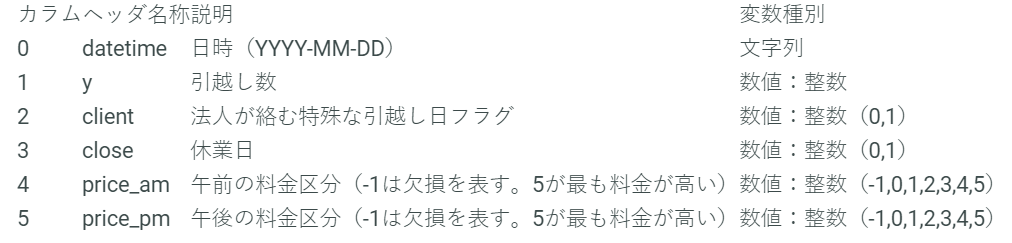


In [21]:
test.head()

,datetime,client,close,price_am,price_pm
0,2016/4/1,1,0,3,2
1,2016/4/2,0,0,5,5
2,2016/4/3,1,0,2,2
3,2016/4/4,1,0,1,1
4,2016/4/5,0,0,1,1


In [24]:
sample_submission.head()

,2016/4/1,65.98920574
0,2016/4/2,73.076330
1,2016/4/3,62.837857
2,2016/4/4,57.607645
3,2016/4/5,56.316084
4,2016/4/6,57.607645


In [25]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (2101, 6)
Testing Features shape:  (365, 5)


**data summary**

In [26]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(train)[:25]

Dataset Shape: (2101, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,datetime,object,0,2101,2010/7/1,2010/7/2,2010/7/3,11.04
1,y,int64,0,99,17,18,20,6.01
2,client,int64,0,2,0,0,0,0.46
3,close,int64,0,2,0,0,0,0.10
4,price_am,int64,0,7,-1,-1,-1,2.03
5,price_pm,int64,0,7,-1,-1,-1,1.76


**check missing value**

in these data, "-1" means missing value on columns price_am, price_pm

In [41]:
ms_count = train['price_am'].value_counts()
percent = ((train.isnull().sum()/train.shape[0])*100).sort_values(ascending=False)
print(ms_count)
print(type(ms_count))
print((211/train.shape[0])*100)

 0    945
 1    587
 2    250
-1    211
 3     46
 4     33
 5     29
Name: price_am, dtype: int64
<class 'pandas.core.series.Series'>
10.042836744407426



*   No missing value in train and test data



# Visualization

In [ ]:
fig, ax = plt.subplots(figsize=(80, 40))
ax.plot(train["datetime"], train["meter_reading"])
plt.xlabel("timestamp", fontsize=10)
plt.ylabel("meter", fontsize=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)